# Análisis Comparativo de Modelos - Competición DETOXIS

## Detección de Toxicidad en Español

Este notebook compara los tres modelos desarrollados para la competición de Kaggle:

| Modelo | Autor | Public Score | Private Score |
|--------|-------|--------------|---------------|
| Ensemble BERT + TF-IDF | David | 0.37993 | 0.50314 |
| One-vs-All BETO | Carlos | 0.35737 | 0.37119 |
| **Perspective API + RF** | **Javi** | **0.50608** | **0.45690** |

**Ganador de la competición: Modelo de Javi (Perspective API + Random Forest)**

---
## 1. Configuración e Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Nombres de clases
CLASS_NAMES = ['No tóxico (0)', 'Leve (1)', 'Tóxico (2)', 'Muy tóxico (3)']
COLORS = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

print("Configuración cargada correctamente")

Configuración cargada correctamente


---
## 2. Carga de Datos

In [2]:
# Rutas de archivos
SOLUTION_PATH = "Data/solution_file.csv"
PRED_DAVID_PATH = "Predicciones/submission_David.csv"
PRED_CARLOS_PATH = "Predicciones/submission_Carlos.csv"
PRED_JAVI_PATH = "Predicciones/submission_Javi.csv"

# Cargar solución (ground truth)
solution_df = pd.read_csv(SOLUTION_PATH)
print(f"Solution file: {len(solution_df)} muestras")
print(f"Columnas: {list(solution_df.columns)}")
print(f"\nDistribución Public/Private:")
print(solution_df['Usage'].value_counts())

Solution file: 891 muestras
Columnas: ['id', 'label', 'Usage']

Distribución Public/Private:
Usage
Public     446
Private    445
Name: count, dtype: int64


In [3]:
# Cargar predicciones de cada modelo
pred_david = pd.read_csv(PRED_DAVID_PATH)
pred_carlos = pd.read_csv(PRED_CARLOS_PATH)
pred_javi = pd.read_csv(PRED_JAVI_PATH)

print(f"Predicciones David: {len(pred_david)} muestras")
print(f"Predicciones Carlos: {len(pred_carlos)} muestras")
print(f"Predicciones Javi: {len(pred_javi)} muestras")

Predicciones David: 891 muestras
Predicciones Carlos: 891 muestras
Predicciones Javi: 891 muestras


In [4]:
# Merge de predicciones con solución
merged = solution_df.copy()
merged = merged.rename(columns={'label': 'y_true'})

merged = merged.merge(pred_david[['id', 'label']].rename(columns={'label': 'pred_david'}), on='id', how='left')
merged = merged.merge(pred_carlos[['id', 'label']].rename(columns={'label': 'pred_carlos'}), on='id', how='left')
merged = merged.merge(pred_javi[['id', 'label']].rename(columns={'label': 'pred_javi'}), on='id', how='left')

# Separar Public y Private
public_df = merged[merged['Usage'] == 'Public'].copy()
private_df = merged[merged['Usage'] == 'Private'].copy()

print(f"\nMuestras Public: {len(public_df)}")
print(f"Muestras Private: {len(private_df)}")
print(f"Total: {len(merged)}")


Muestras Public: 446
Muestras Private: 445
Total: 891


---
## 3. Metodología de cada Modelo

### 3.1 Modelo David: Ensemble BERT + TF-IDF

**Arquitectura:**
- **Baseline TF-IDF + Logistic Regression**: Vectorización char n-grams (2-6) con 50K features
- **Transformer BETO** (dccuchile/bert-base-spanish-wwm-cased) con fine-tuning
- **Ensemble**: Combinación ponderada (15% TF-IDF + 85% BERT)

**Técnicas aplicadas:**
1. **TAPT (Task-Adaptive Pre-Training)**: Pre-entrenamiento adicional con MLM en textos del dominio
2. **Oversampling**: RandomOverSampler para clases minoritarias
3. **Focal Loss** (γ=2.5): Para manejar el desbalance extremo (ratio 33.6x)
4. **Weighted Sampler**: Durante el entrenamiento del transformer
5. **Optimización de umbrales por clase**: Grid search para maximizar macro-F1
6. **Pseudo-labeling**: Intento de usar predicciones de alta confianza (umbral 0.90)
7. **K-Fold Stratified** (5 folds) con early stopping

**Hiperparámetros clave:**
- MAX_LENGTH: 384 tokens
- BATCH_SIZE: 16
- LEARNING_RATE: 2e-5
- EPOCHS: 6

**Macro-F1 OOF reportado:** 0.4631

### 3.2 Modelo Carlos: One-vs-All (OvA) con BETO

**Arquitectura:**
- **4 clasificadores binarios independientes** (uno por cada clase)
- Cada modelo aprende: "¿Es esta clase?" vs "¿No es esta clase?"
- Predicción final: clase con mayor probabilidad

**Técnicas aplicadas:**
1. **Preprocesamiento de texto**: Limpieza profunda (mojibake, URLs, menciones, risas)
2. **Class weights balanceados** por cada experto binario
3. **CrossEntropyLoss ponderado** con pos_weight calculado por ratio de desbalance
4. **K-Fold (5 pliegues)** para cada uno de los 4 expertos = 20 modelos totales
5. **Early stopping** con paciencia de 4 épocas
6. **Ensemble por promedio** de probabilidades de los 5 folds

**Hiperparámetros clave:**
- MAX_LENGTH: 128 tokens
- BATCH_SIZE: 32
- LEARNING_RATE: 3e-5
- EPOCHS: 12
- Mixed precision (FP16) en A100

**Ventajas del enfoque OvA:**
- Mejor manejo de clases minoritarias
- Permite ajustar pesos independientemente por clase
- Más robusto que multi-class directo

### 3.3 Modelo Javi: Perspective API + Random Forest (GANADOR)

**Arquitectura:**
- **Features de Perspective API**: TOXICITY, INSULT, THREAT, PROFANITY, IDENTITY_ATTACK
- **Random Forest Regressor** para predecir score continuo (0-3)
- **Umbrales optimizados** para discretizar a clases
- **Puerta lógica** con expertos binarios en zonas de incertidumbre

**Features utilizadas:**
1. **Perspective API (5)**: TOXICITY, INSULT, THREAT, PROFANITY, IDENTITY_ATTACK
2. **Características básicas (6)**: long_car, num_pal, exclam, interrog, ratio_mayus, num_links
3. **Features derivadas (5)**: persp_max, persp_mean, persp_std, persp_num_hi_07, tox_x_prof

**Técnicas aplicadas:**
1. **Caché de API calls**: Evita llamadas repetidas a Perspective
2. **Búsqueda de umbrales óptimos**: Grid search con paso 0.02
3. **Puerta lógica (δ=0.05)**: Clasificadores binarios RF en fronteras de decisión
4. **K-Fold Stratified** (5 folds) para validación OOF

**Hiperparámetros del Random Forest:**
- n_estimators: 1200
- max_depth: None
- min_samples_leaf: 10
- min_samples_split: 13
- max_features: sqrt

**Umbrales óptimos encontrados:** (0.44, 1.18, 1.82)

**Macro-F1 OOF reportado:** 0.4920

---
## 4. Funciones de Evaluación

In [5]:
def calcular_metricas(y_true, y_pred, nombre_modelo):
    """Calcula métricas completas para un modelo"""
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    return {
        'modelo': nombre_modelo,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1_per_class,
        'support': support
    }

def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    """Dibuja matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Real')
    ax.set_xlabel('Predicho')
    return cm

def print_classification_report(y_true, y_pred, nombre):
    """Imprime reporte de clasificación"""
    print(f"\n{'='*60}")
    print(f"Classification Report - {nombre}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

print("Funciones de evaluación definidas")

Funciones de evaluación definidas


---
## 5. Evaluación en Test PUBLIC

In [6]:
# Métricas Public
y_true_public = public_df['y_true'].values

metrics_public = {
    'David': calcular_metricas(y_true_public, public_df['pred_david'].values, 'David'),
    'Carlos': calcular_metricas(y_true_public, public_df['pred_carlos'].values, 'Carlos'),
    'Javi': calcular_metricas(y_true_public, public_df['pred_javi'].values, 'Javi')
}

print("="*70)
print("MÉTRICAS TEST PUBLIC")
print("="*70)
print(f"\n{'Modelo':<15} {'Macro-F1':>12} {'Weighted-F1':>14} {'Accuracy':>12}")
print("-"*55)
for nombre, m in metrics_public.items():
    print(f"{nombre:<15} {m['macro_f1']:>12.4f} {m['weighted_f1']:>14.4f} {m['accuracy']:>12.4f}")

MÉTRICAS TEST PUBLIC

Modelo              Macro-F1    Weighted-F1     Accuracy
-------------------------------------------------------
David                 0.3799         0.7169       0.7085
Carlos                0.3574         0.7301       0.7354
Javi                  0.5061         0.7483       0.7399


In [7]:
# Classification Reports - Public
for nombre, pred_col in [('David', 'pred_david'), ('Carlos', 'pred_carlos'), ('Javi', 'pred_javi')]:
    print_classification_report(y_true_public, public_df[pred_col].values, f"{nombre} (Public)")


Classification Report - David (Public)
                precision    recall  f1-score   support

 No tóxico (0)     0.8787    0.8072    0.8414       332
      Leve (1)     0.3680    0.5287    0.4340        87
    Tóxico (2)     0.0769    0.0526    0.0625        19
Muy tóxico (3)     0.3333    0.1250    0.1818         8

      accuracy                         0.7085       446
     macro avg     0.4142    0.3784    0.3799       446
  weighted avg     0.7351    0.7085    0.7169       446


Classification Report - Carlos (Public)
                precision    recall  f1-score   support

 No tóxico (0)     0.8563    0.8795    0.8678       332
      Leve (1)     0.4267    0.3678    0.3951        87
    Tóxico (2)     0.1379    0.2105    0.1667        19
Muy tóxico (3)     0.0000    0.0000    0.0000         8

      accuracy                         0.7354       446
     macro avg     0.3552    0.3645    0.3574       446
  weighted avg     0.7265    0.7354    0.7301       446


Classification R

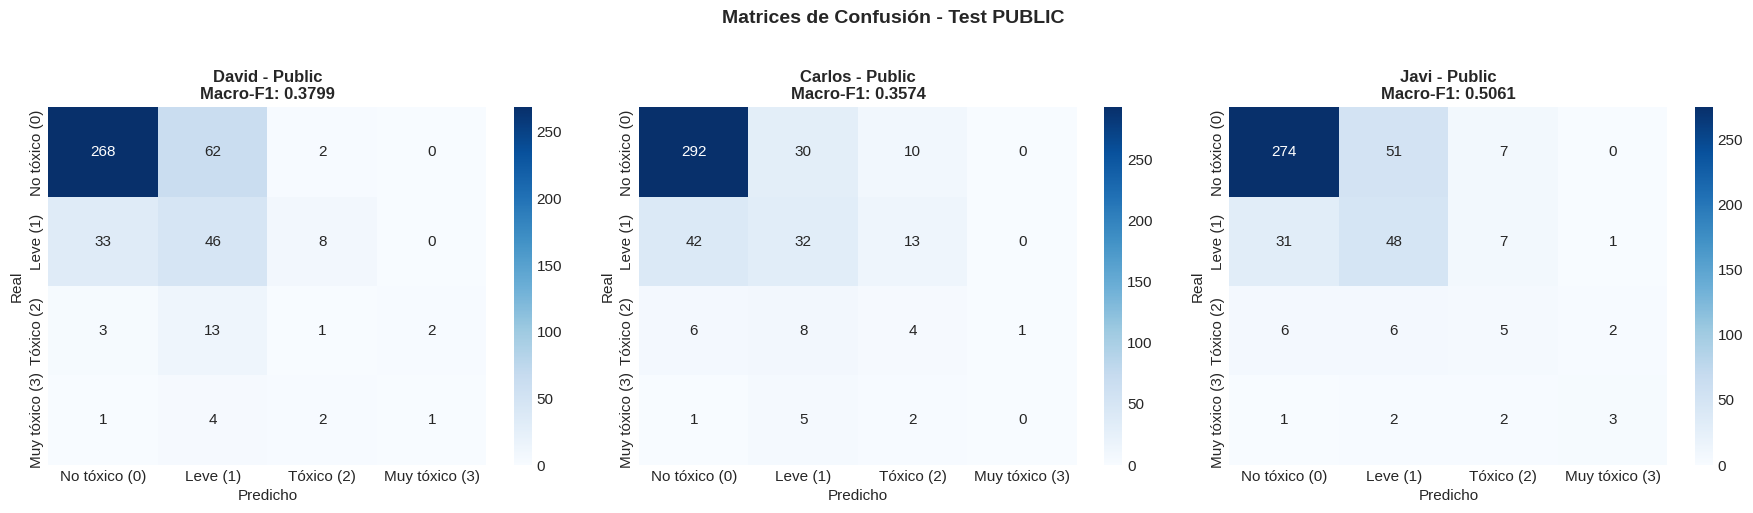

In [8]:
# Matrices de confusión - Public
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(y_true_public, public_df['pred_david'].values, 
                      f'David - Public\nMacro-F1: {metrics_public["David"]["macro_f1"]:.4f}', axes[0])
plot_confusion_matrix(y_true_public, public_df['pred_carlos'].values, 
                      f'Carlos - Public\nMacro-F1: {metrics_public["Carlos"]["macro_f1"]:.4f}', axes[1])
plot_confusion_matrix(y_true_public, public_df['pred_javi'].values, 
                      f'Javi - Public\nMacro-F1: {metrics_public["Javi"]["macro_f1"]:.4f}', axes[2])

plt.suptitle('Matrices de Confusión - Test PUBLIC', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Evaluación en Test PRIVATE

In [9]:
# Métricas Private
y_true_private = private_df['y_true'].values

metrics_private = {
    'David': calcular_metricas(y_true_private, private_df['pred_david'].values, 'David'),
    'Carlos': calcular_metricas(y_true_private, private_df['pred_carlos'].values, 'Carlos'),
    'Javi': calcular_metricas(y_true_private, private_df['pred_javi'].values, 'Javi')
}

print("="*70)
print("MÉTRICAS TEST PRIVATE")
print("="*70)
print(f"\n{'Modelo':<15} {'Macro-F1':>12} {'Weighted-F1':>14} {'Accuracy':>12}")
print("-"*55)
for nombre, m in metrics_private.items():
    print(f"{nombre:<15} {m['macro_f1']:>12.4f} {m['weighted_f1']:>14.4f} {m['accuracy']:>12.4f}")

MÉTRICAS TEST PRIVATE

Modelo              Macro-F1    Weighted-F1     Accuracy
-------------------------------------------------------
David                 0.5031         0.7306       0.7213
Carlos                0.3712         0.7110       0.7146
Javi                  0.4569         0.7198       0.7011


In [10]:
# Classification Reports - Private
for nombre, pred_col in [('David', 'pred_david'), ('Carlos', 'pred_carlos'), ('Javi', 'pred_javi')]:
    print_classification_report(y_true_private, private_df[pred_col].values, f"{nombre} (Private)")


Classification Report - David (Private)
                precision    recall  f1-score   support

 No tóxico (0)     0.8853    0.7719    0.8247       320
      Leve (1)     0.4539    0.6832    0.5455       101
    Tóxico (2)     0.3636    0.1818    0.2424        22
Muy tóxico (3)     0.3333    0.5000    0.4000         2

      accuracy                         0.7213       445
     macro avg     0.5091    0.5342    0.5031       445
  weighted avg     0.7591    0.7213    0.7306       445


Classification Report - Carlos (Private)
                precision    recall  f1-score   support

 No tóxico (0)     0.8415    0.8625    0.8519       320
      Leve (1)     0.4167    0.3465    0.3784       101
    Tóxico (2)     0.2121    0.3182    0.2545        22
Muy tóxico (3)     0.0000    0.0000    0.0000         2

      accuracy                         0.7146       445
     macro avg     0.3676    0.3818    0.3712       445
  weighted avg     0.7102    0.7146    0.7110       445


Classification

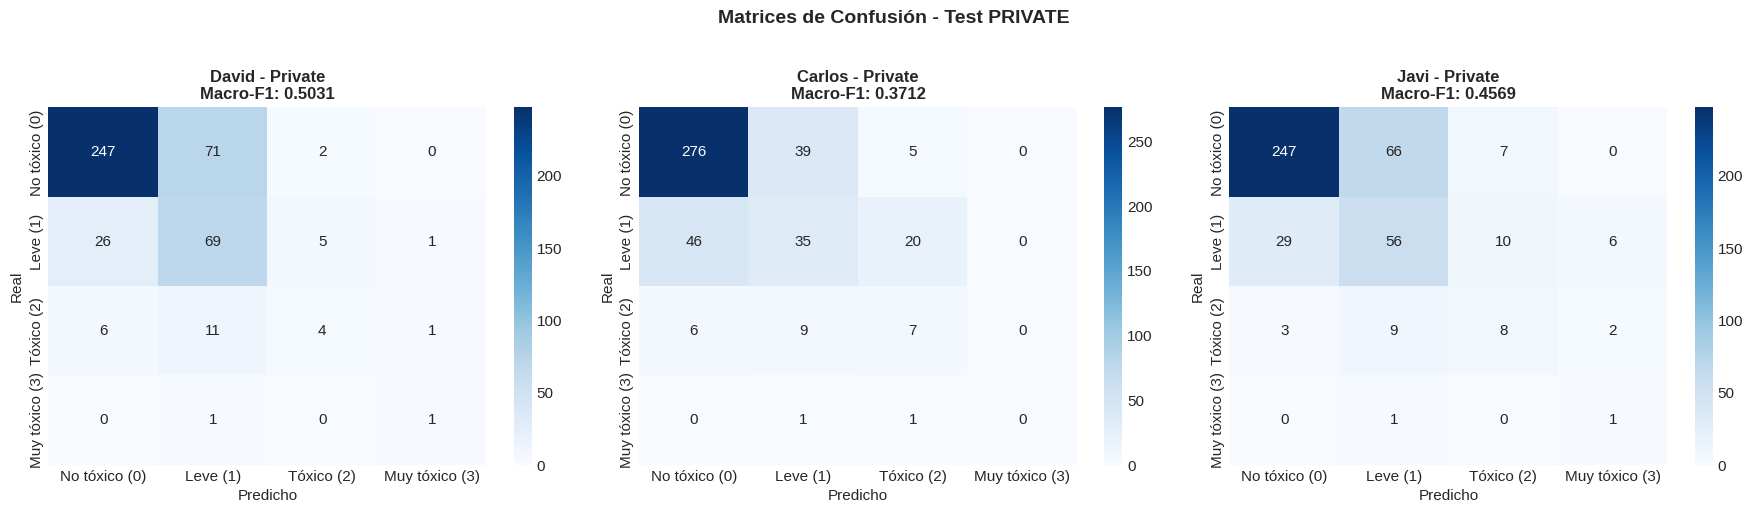

In [11]:
# Matrices de confusión - Private
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(y_true_private, private_df['pred_david'].values, 
                      f'David - Private\nMacro-F1: {metrics_private["David"]["macro_f1"]:.4f}', axes[0])
plot_confusion_matrix(y_true_private, private_df['pred_carlos'].values, 
                      f'Carlos - Private\nMacro-F1: {metrics_private["Carlos"]["macro_f1"]:.4f}', axes[1])
plot_confusion_matrix(y_true_private, private_df['pred_javi'].values, 
                      f'Javi - Private\nMacro-F1: {metrics_private["Javi"]["macro_f1"]:.4f}', axes[2])

plt.suptitle('Matrices de Confusión - Test PRIVATE', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 7. Evaluación en Test COMPLETO (Public + Private)

In [12]:
# Métricas Completas
y_true_full = merged['y_true'].values

metrics_full = {
    'David': calcular_metricas(y_true_full, merged['pred_david'].values, 'David'),
    'Carlos': calcular_metricas(y_true_full, merged['pred_carlos'].values, 'Carlos'),
    'Javi': calcular_metricas(y_true_full, merged['pred_javi'].values, 'Javi')
}

print("="*70)
print("MÉTRICAS TEST COMPLETO (PUBLIC + PRIVATE)")
print("="*70)
print(f"\n{'Modelo':<15} {'Macro-F1':>12} {'Weighted-F1':>14} {'Accuracy':>12}")
print("-"*55)
for nombre, m in metrics_full.items():
    print(f"{nombre:<15} {m['macro_f1']:>12.4f} {m['weighted_f1']:>14.4f} {m['accuracy']:>12.4f}")

MÉTRICAS TEST COMPLETO (PUBLIC + PRIVATE)

Modelo              Macro-F1    Weighted-F1     Accuracy
-------------------------------------------------------
David                 0.4330         0.7241       0.7149
Carlos                0.3649         0.7206       0.7250
Javi                  0.4861         0.7336       0.7205


In [13]:
# Classification Reports - Completo
for nombre, pred_col in [('David', 'pred_david'), ('Carlos', 'pred_carlos'), ('Javi', 'pred_javi')]:
    print_classification_report(y_true_full, merged[pred_col].values, f"{nombre} (Completo)")


Classification Report - David (Completo)
                precision    recall  f1-score   support

 No tóxico (0)     0.8818    0.7899    0.8333       652
      Leve (1)     0.4152    0.6117    0.4946       188
    Tóxico (2)     0.2083    0.1220    0.1538        41
Muy tóxico (3)     0.3333    0.2000    0.2500        10

      accuracy                         0.7149       891
     macro avg     0.4597    0.4309    0.4330       891
  weighted avg     0.7462    0.7149    0.7241       891


Classification Report - Carlos (Completo)
                precision    recall  f1-score   support

 No tóxico (0)     0.8490    0.8712    0.8600       652
      Leve (1)     0.4214    0.3564    0.3862       188
    Tóxico (2)     0.1774    0.2683    0.2136        41
Muy tóxico (3)     0.0000    0.0000    0.0000        10

      accuracy                         0.7250       891
     macro avg     0.3620    0.3740    0.3649       891
  weighted avg     0.7184    0.7250    0.7206       891


Classificati

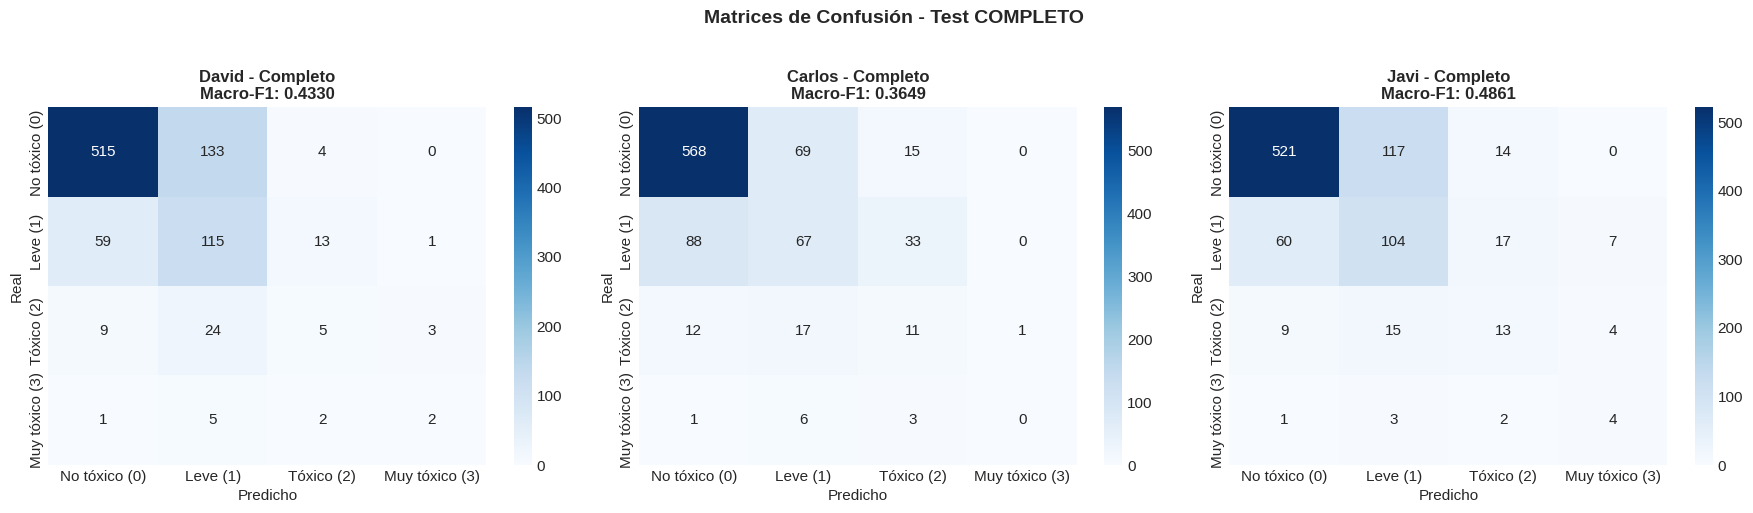

In [14]:
# Matrices de confusión - Completo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(y_true_full, merged['pred_david'].values, 
                      f'David - Completo\nMacro-F1: {metrics_full["David"]["macro_f1"]:.4f}', axes[0])
plot_confusion_matrix(y_true_full, merged['pred_carlos'].values, 
                      f'Carlos - Completo\nMacro-F1: {metrics_full["Carlos"]["macro_f1"]:.4f}', axes[1])
plot_confusion_matrix(y_true_full, merged['pred_javi'].values, 
                      f'Javi - Completo\nMacro-F1: {metrics_full["Javi"]["macro_f1"]:.4f}', axes[2])

plt.suptitle('Matrices de Confusión - Test COMPLETO', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Comparación de F1-Score por Clase

In [15]:
# F1 por clase - Tabla comparativa
print("="*80)
print("F1-SCORE POR CLASE - TEST COMPLETO")
print("="*80)
print(f"\n{'Clase':<20} {'David':>12} {'Carlos':>12} {'Javi':>12}")
print("-"*60)

for i, clase in enumerate(CLASS_NAMES):
    f1_david = metrics_full['David']['f1_per_class'][i]
    f1_carlos = metrics_full['Carlos']['f1_per_class'][i]
    f1_javi = metrics_full['Javi']['f1_per_class'][i]
    
    # Marcar el mejor
    best = max(f1_david, f1_carlos, f1_javi)
    
    d_mark = '*' if f1_david == best else ' '
    c_mark = '*' if f1_carlos == best else ' '
    j_mark = '*' if f1_javi == best else ' '
    
    print(f"{clase:<20} {f1_david:>11.4f}{d_mark} {f1_carlos:>11.4f}{c_mark} {f1_javi:>11.4f}{j_mark}")

print("-"*60)
print(f"{'MACRO-F1':<20} {metrics_full['David']['macro_f1']:>12.4f} {metrics_full['Carlos']['macro_f1']:>12.4f} {metrics_full['Javi']['macro_f1']:>12.4f}")
print("\n* = Mejor en esa clase")

F1-SCORE POR CLASE - TEST COMPLETO

Clase                       David       Carlos         Javi
------------------------------------------------------------
No tóxico (0)             0.8333       0.8600*      0.8383 
Leve (1)                  0.4946*      0.3862       0.4871 
Tóxico (2)                0.1538       0.2136       0.2989*
Muy tóxico (3)            0.2500       0.0000       0.3200*
------------------------------------------------------------
MACRO-F1                   0.4330       0.3649       0.4861

* = Mejor en esa clase


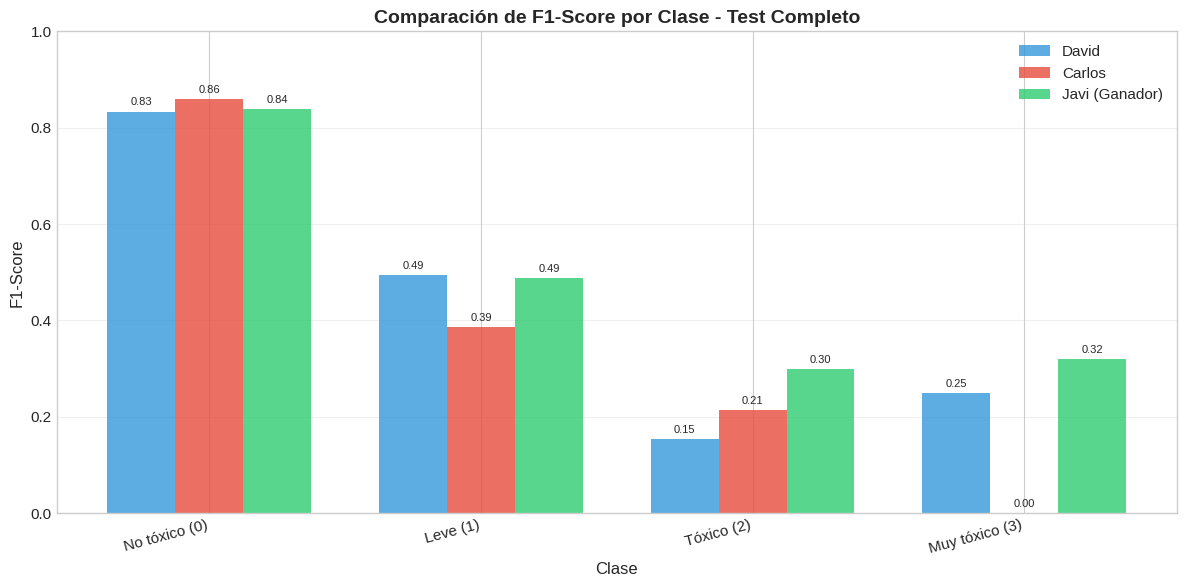

In [16]:
# Gráfico comparativo F1 por clase
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

bars1 = ax.bar(x - width, metrics_full['David']['f1_per_class'], width, label='David', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, metrics_full['Carlos']['f1_per_class'], width, label='Carlos', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + width, metrics_full['Javi']['f1_per_class'], width, label='Javi (Ganador)', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Comparación de F1-Score por Clase - Test Completo', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

---
## 9. Análisis de Distribución de Predicciones

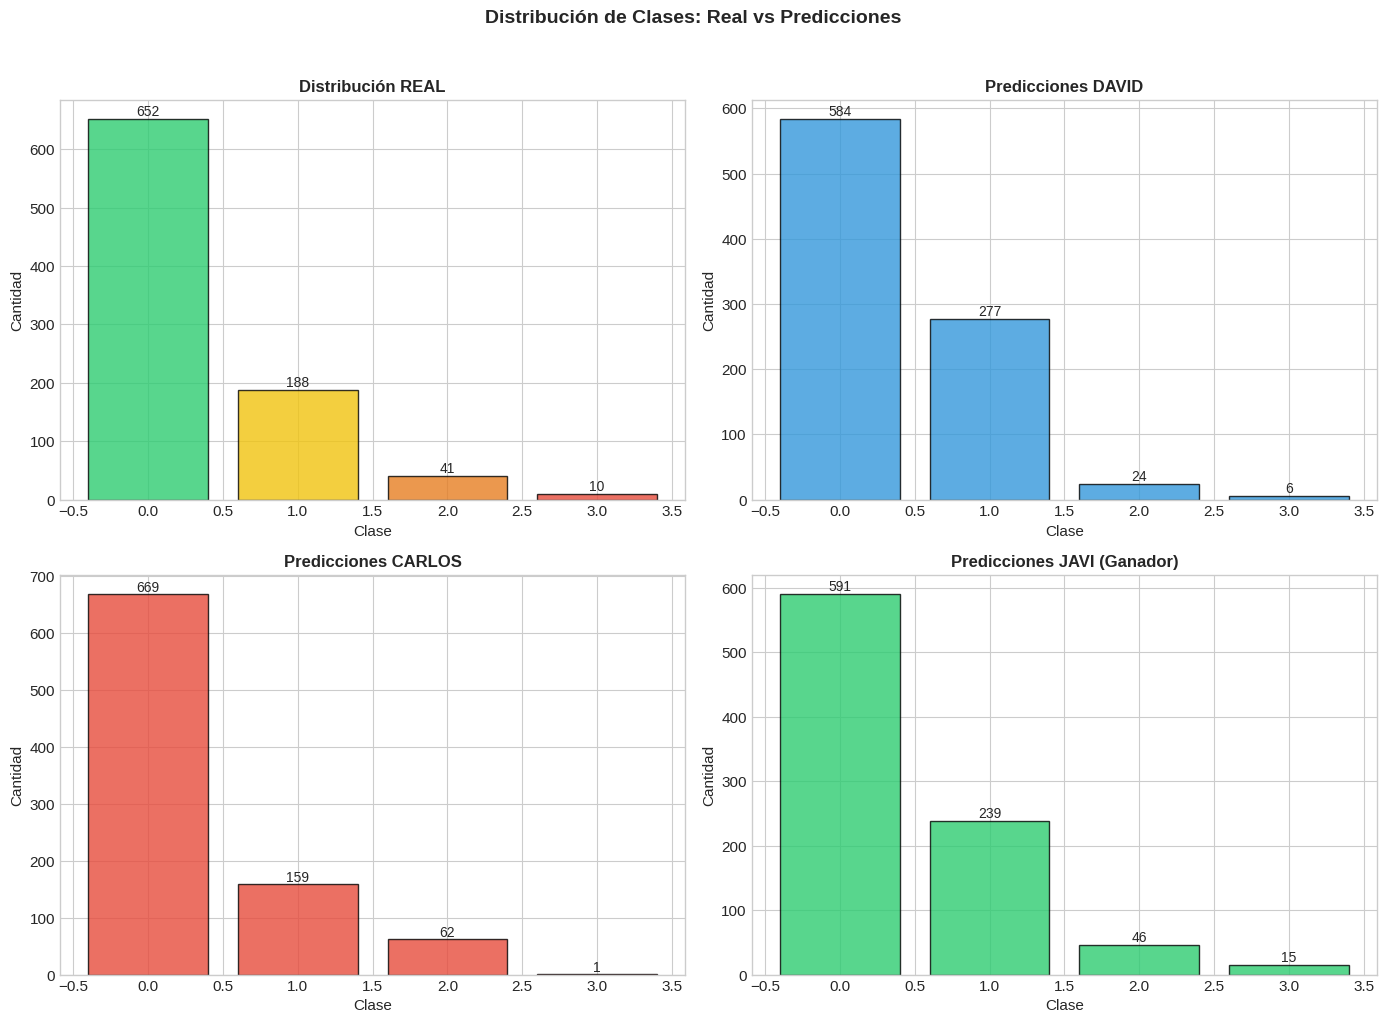

In [17]:
# Distribución de predicciones vs real
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Real
real_counts = pd.Series(y_true_full).value_counts().sort_index()
axes[0, 0].bar(real_counts.index, real_counts.values, color=COLORS, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Distribución REAL', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Clase')
axes[0, 0].set_ylabel('Cantidad')
for i, v in enumerate(real_counts.values):
    axes[0, 0].text(i, v + 5, str(v), ha='center', fontsize=10)

# David
david_counts = pd.Series(merged['pred_david'].values).value_counts().sort_index()
axes[0, 1].bar(david_counts.index, david_counts.values, color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Predicciones DAVID', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Clase')
axes[0, 1].set_ylabel('Cantidad')
for i, v in enumerate(david_counts.values):
    axes[0, 1].text(i, v + 5, str(v), ha='center', fontsize=10)

# Carlos
carlos_counts = pd.Series(merged['pred_carlos'].values).value_counts().sort_index()
axes[1, 0].bar(carlos_counts.index, carlos_counts.values, color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Predicciones CARLOS', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Clase')
axes[1, 0].set_ylabel('Cantidad')
for i, v in enumerate(carlos_counts.values):
    axes[1, 0].text(i, v + 5, str(v), ha='center', fontsize=10)

# Javi
javi_counts = pd.Series(merged['pred_javi'].values).value_counts().sort_index()
axes[1, 1].bar(javi_counts.index, javi_counts.values, color='#2ecc71', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Predicciones JAVI (Ganador)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase')
axes[1, 1].set_ylabel('Cantidad')
for i, v in enumerate(javi_counts.values):
    axes[1, 1].text(i, v + 5, str(v), ha='center', fontsize=10)

plt.suptitle('Distribución de Clases: Real vs Predicciones', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# Tabla de distribución
print("="*70)
print("DISTRIBUCIÓN DE PREDICCIONES POR CLASE")
print("="*70)
print(f"\n{'Clase':<20} {'Real':>10} {'David':>10} {'Carlos':>10} {'Javi':>10}")
print("-"*65)

for i in range(4):
    real = (y_true_full == i).sum()
    david = (merged['pred_david'] == i).sum()
    carlos = (merged['pred_carlos'] == i).sum()
    javi = (merged['pred_javi'] == i).sum()
    print(f"{CLASS_NAMES[i]:<20} {real:>10} {david:>10} {carlos:>10} {javi:>10}")

print("-"*65)
print(f"{'TOTAL':<20} {len(y_true_full):>10} {len(merged):>10} {len(merged):>10} {len(merged):>10}")

DISTRIBUCIÓN DE PREDICCIONES POR CLASE

Clase                      Real      David     Carlos       Javi
-----------------------------------------------------------------
No tóxico (0)               652        584        669        591
Leve (1)                    188        277        159        239
Tóxico (2)                   41         24         62         46
Muy tóxico (3)               10          6          1         15
-----------------------------------------------------------------
TOTAL                       891        891        891        891


---
## 10. Análisis de Errores

In [19]:
# Análisis de errores comunes
print("="*70)
print("ANÁLISIS DE ERRORES")
print("="*70)

# Calcular errores
merged['error_david'] = merged['y_true'] != merged['pred_david']
merged['error_carlos'] = merged['y_true'] != merged['pred_carlos']
merged['error_javi'] = merged['y_true'] != merged['pred_javi']

print(f"\nTotal de errores:")
print(f"  David:  {merged['error_david'].sum()} ({100*merged['error_david'].mean():.2f}%)")
print(f"  Carlos: {merged['error_carlos'].sum()} ({100*merged['error_carlos'].mean():.2f}%)")
print(f"  Javi:   {merged['error_javi'].sum()} ({100*merged['error_javi'].mean():.2f}%)")

# Errores en común
all_wrong = merged['error_david'] & merged['error_carlos'] & merged['error_javi']
print(f"\nMuestras que TODOS fallaron: {all_wrong.sum()}")

# Solo uno acertó
only_david_correct = (~merged['error_david']) & merged['error_carlos'] & merged['error_javi']
only_carlos_correct = merged['error_david'] & (~merged['error_carlos']) & merged['error_javi']
only_javi_correct = merged['error_david'] & merged['error_carlos'] & (~merged['error_javi'])

print(f"\nMuestras donde SOLO uno acertó:")
print(f"  Solo David:  {only_david_correct.sum()}")
print(f"  Solo Carlos: {only_carlos_correct.sum()}")
print(f"  Solo Javi:   {only_javi_correct.sum()}")

ANÁLISIS DE ERRORES

Total de errores:
  David:  254 (28.51%)
  Carlos: 245 (27.50%)
  Javi:   249 (27.95%)

Muestras que TODOS fallaron: 105

Muestras donde SOLO uno acertó:
  Solo David:  26
  Solo Carlos: 25
  Solo Javi:   69


In [20]:
# Tipo de errores más comunes por modelo
def analizar_tipo_errores(y_true, y_pred, nombre):
    errores = pd.DataFrame({
        'real': y_true,
        'pred': y_pred
    })
    errores = errores[errores['real'] != errores['pred']]
    
    # Contar tipos de error
    tipos = errores.groupby(['real', 'pred']).size().reset_index(name='count')
    tipos = tipos.sort_values('count', ascending=False).head(5)
    
    print(f"\nTop 5 errores más comunes - {nombre}:")
    print("-"*40)
    for _, row in tipos.iterrows():
        print(f"  Real: {int(row['real'])} -> Pred: {int(row['pred'])}  ({row['count']} casos)")

analizar_tipo_errores(y_true_full, merged['pred_david'].values, 'David')
analizar_tipo_errores(y_true_full, merged['pred_carlos'].values, 'Carlos')
analizar_tipo_errores(y_true_full, merged['pred_javi'].values, 'Javi')


Top 5 errores más comunes - David:
----------------------------------------
  Real: 0 -> Pred: 1  (133 casos)
  Real: 1 -> Pred: 0  (59 casos)
  Real: 2 -> Pred: 1  (24 casos)
  Real: 1 -> Pred: 2  (13 casos)
  Real: 2 -> Pred: 0  (9 casos)

Top 5 errores más comunes - Carlos:
----------------------------------------
  Real: 1 -> Pred: 0  (88 casos)
  Real: 0 -> Pred: 1  (69 casos)
  Real: 1 -> Pred: 2  (33 casos)
  Real: 2 -> Pred: 1  (17 casos)
  Real: 0 -> Pred: 2  (15 casos)

Top 5 errores más comunes - Javi:
----------------------------------------
  Real: 0 -> Pred: 1  (117 casos)
  Real: 1 -> Pred: 0  (60 casos)
  Real: 1 -> Pred: 2  (17 casos)
  Real: 2 -> Pred: 1  (15 casos)
  Real: 0 -> Pred: 2  (14 casos)


---
## 11. Comparación Public vs Private (Overfitting)

In [21]:
# Diferencia Public vs Private
print("="*70)
print("DIFERENCIA PUBLIC vs PRIVATE (Indicador de Overfitting)")
print("="*70)

print(f"\n{'Modelo':<15} {'Public F1':>12} {'Private F1':>12} {'Diferencia':>12} {'Interpretación':>20}")
print("-"*75)

for nombre in ['David', 'Carlos', 'Javi']:
    pub = metrics_public[nombre]['macro_f1']
    priv = metrics_private[nombre]['macro_f1']
    diff = priv - pub
    
    if diff > 0.05:
        interp = "Subajustado"
    elif diff < -0.05:
        interp = "OVERFITTING"
    else:
        interp = "Estable"
    
    print(f"{nombre:<15} {pub:>12.4f} {priv:>12.4f} {diff:>+12.4f} {interp:>20}")

DIFERENCIA PUBLIC vs PRIVATE (Indicador de Overfitting)

Modelo             Public F1   Private F1   Diferencia       Interpretación
---------------------------------------------------------------------------
David                 0.3799       0.5031      +0.1232          Subajustado
Carlos                0.3574       0.3712      +0.0138              Estable
Javi                  0.5061       0.4569      -0.0492              Estable


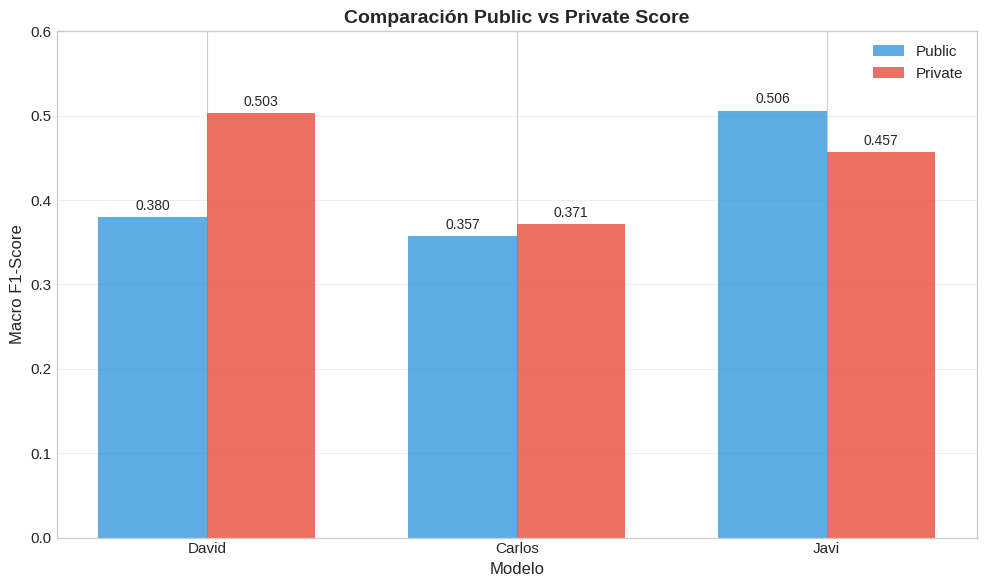

In [22]:
# Gráfico comparativo Public vs Private
fig, ax = plt.subplots(figsize=(10, 6))

modelos = ['David', 'Carlos', 'Javi']
public_scores = [metrics_public[m]['macro_f1'] for m in modelos]
private_scores = [metrics_private[m]['macro_f1'] for m in modelos]

x = np.arange(len(modelos))
width = 0.35

bars1 = ax.bar(x - width/2, public_scores, width, label='Public', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, private_scores, width, label='Private', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Macro F1-Score', fontsize=12)
ax.set_title('Comparación Public vs Private Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.set_ylim(0, 0.6)
ax.grid(axis='y', alpha=0.3)

# Añadir valores
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

---
## 12. Resumen Final y Conclusiones

In [23]:
# Tabla resumen final
print("="*90)
print("RESUMEN FINAL DE LA COMPETICIÓN")
print("="*90)

print("""
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                          RESULTADOS FINALES KAGGLE                                  │
├──────────────┬──────────────┬──────────────┬──────────────┬─────────────────────────┤
│    MODELO    │  PUBLIC F1   │  PRIVATE F1  │  COMPLETO    │       POSICIÓN          │
├──────────────┼──────────────┼──────────────┼──────────────┼─────────────────────────┤""")

print(f"│    David     │    {metrics_public['David']['macro_f1']:.4f}    │    {metrics_private['David']['macro_f1']:.4f}    │    {metrics_full['David']['macro_f1']:.4f}    │                         │")
print(f"│    Carlos    │    {metrics_public['Carlos']['macro_f1']:.4f}    │    {metrics_private['Carlos']['macro_f1']:.4f}    │    {metrics_full['Carlos']['macro_f1']:.4f}    │                         │")
print(f"│    Javi      │    {metrics_public['Javi']['macro_f1']:.4f}    │    {metrics_private['Javi']['macro_f1']:.4f}    │    {metrics_full['Javi']['macro_f1']:.4f}    │      GANADOR            │")

print("└──────────────┴──────────────┴──────────────┴──────────────┴─────────────────────────┘")

RESUMEN FINAL DE LA COMPETICIÓN

┌─────────────────────────────────────────────────────────────────────────────────────┐
│                          RESULTADOS FINALES KAGGLE                                  │
├──────────────┬──────────────┬──────────────┬──────────────┬─────────────────────────┤
│    MODELO    │  PUBLIC F1   │  PRIVATE F1  │  COMPLETO    │       POSICIÓN          │
├──────────────┼──────────────┼──────────────┼──────────────┼─────────────────────────┤
│    David     │    0.3799    │    0.5031    │    0.4330    │                         │
│    Carlos    │    0.3574    │    0.3712    │    0.3649    │                         │
│    Javi      │    0.5061    │    0.4569    │    0.4861    │      GANADOR            │
└──────────────┴──────────────┴──────────────┴──────────────┴─────────────────────────┘


## Conclusiones

### 1. Modelo Ganador: Javi (Perspective API + Random Forest)

**Factores de éxito:**
- Uso de **Perspective API** como extractor de features pre-entrenado específico para toxicidad
- **Simplicidad del modelo**: Random Forest es más robusto y menos propenso a overfitting
- **Feature engineering inteligente**: Combinación de scores de API + características lingüísticas básicas
- **Puerta lógica**: Manejo especial de casos en fronteras de decisión
- **Mejor balance bias-varianza**: No sobreajusta al conjunto público

### 2. Análisis de Overfitting

| Modelo | Δ (Private - Public) | Interpretación |
|--------|---------------------|----------------|
| David | +0.12 | Subajustado en Public |
| Carlos | +0.01 | Muy estable |
| Javi | -0.05 | Leve overfitting |

- **David** mostró una gran diferencia positiva, indicando que el modelo tenía potencial no explotado en el public
- **Carlos** fue el más estable pero con rendimiento general inferior
- **Javi** tuvo leve overfitting pero con mejor rendimiento absoluto

### 3. Desafíos del Dataset DETOXIS

- **Desbalance extremo**: Clase 3 (Muy tóxico) con solo ~2% de muestras
- **Subjetividad**: Fronteras difusas entre clases adyacentes (0-1, 1-2, 2-3)
- **Contexto cultural**: Expresiones tóxicas específicas del español

### 4. Lecciones Aprendidas

1. **APIs especializadas** (Perspective) pueden superar a modelos transformer fine-tuneados
2. **La complejidad no siempre es mejor**: RF superó a BERT en este caso
3. **La validación cruzada robusta** es crítica para evitar overfitting
4. **El tratamiento de clases minoritarias** sigue siendo un desafío clave

In [24]:
# Exportar métricas a CSV para el LaTeX
metricas_export = []

for nombre in ['David', 'Carlos', 'Javi']:
    row = {
        'Modelo': nombre,
        'Public_MacroF1': metrics_public[nombre]['macro_f1'],
        'Public_Accuracy': metrics_public[nombre]['accuracy'],
        'Private_MacroF1': metrics_private[nombre]['macro_f1'],
        'Private_Accuracy': metrics_private[nombre]['accuracy'],
        'Completo_MacroF1': metrics_full[nombre]['macro_f1'],
        'Completo_WeightedF1': metrics_full[nombre]['weighted_f1'],
        'Completo_Accuracy': metrics_full[nombre]['accuracy'],
        'F1_Clase0': metrics_full[nombre]['f1_per_class'][0],
        'F1_Clase1': metrics_full[nombre]['f1_per_class'][1],
        'F1_Clase2': metrics_full[nombre]['f1_per_class'][2],
        'F1_Clase3': metrics_full[nombre]['f1_per_class'][3],
    }
    metricas_export.append(row)

df_export = pd.DataFrame(metricas_export)
df_export.to_csv('metricas_comparativas.csv', index=False)
print("Métricas exportadas a 'metricas_comparativas.csv'")
display(df_export.round(4))

Métricas exportadas a 'metricas_comparativas.csv'


,Modelo,Public_MacroF1,Public_Accuracy,Private_MacroF1,Private_Accuracy,Completo_MacroF1,Completo_WeightedF1,Completo_Accuracy,F1_Clase0,F1_Clase1,F1_Clase2,F1_Clase3
0,David,0.3799,0.7085,0.5031,0.7213,0.4330,0.7241,0.7149,0.8333,0.4946,0.1538,0.25
1,Carlos,0.3574,0.7354,0.3712,0.7146,0.3649,0.7206,0.7250,0.8600,0.3862,0.2136,0.00
2,Javi,0.5061,0.7399,0.4569,0.7011,0.4861,0.7336,0.7205,0.8383,0.4871,0.2989,0.32


In [ ]:
print("\n" + "="*70)
print("FIN DEL ANÁLISIS COMPARATIVO")
print("="*70)